<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:tomato' role="tab" aria-controls="home"><center>Cross-Sell Insurance Case Study</center></h2>


## *Business Problem Overview* ¶
A consumer bank with a range of products would like to cross-sell insurance to its consumer base (that is, cross-sell the personal protection insurance (PPI) product to those customers who have a secured or unsecured type of loan, but no PPI product as yet).


## *Business objective*¶
The bank would like to adopt analytics driven approach applied on this sample data for deciding:
- Who should they target from the pool of customers that currently do not have a PPI, and
- What type of PPI product they should be targeting them with

### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:,.2f}'.format
sns.set_context("poster", font_scale = 0.7, rc={"grid.linewidth": 5})
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as xgb
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

In [2]:
# Reading Data
df= pd.read_excel('Mortgage Insurance Cross Sell - Dataset.xls')
df = df.drop('Ref',axis=1) # dropping reference number as it is same as index
df.head(3)

,Credit_Score,Final_Grade,Term,Net_Advance,APR,Loan_Type,Mosaic,Mosaic_Class,Time_at_Address,Residential_Status,...,CIFAS_detected,Time_since_most_recent_outstandi,Insurance_Description,PPI,code,prdt_desc,category,PPI_SINGLE,PPI_JOINT,PPI_LCI
0,918,A,36,"3,000.00",14.40,UnSecured,46,8,132,H,...,N,16,NaN,0,nan,NaN,NaN,0,0,0
1,903,A,120,"21,000.00",7.90,secured,16,3,288,H,...,N,99,Life & Critical Illn,1,748.00,LIFE & CRITICAL ILLNESS,LCI,0,0,1
2,1060,X,78,"7,200.00",7.90,secured,17,3,276,H,...,N,50,Joint,1,719.00,LASCI JOINT,Joint,0,1,0


In [3]:
print(df.shape)
# Summary and checking outliers
df.describe(percentiles=[0.25,0.5,0.75,0.99])

(16383, 58)


,Credit_Score,Term,Net_Advance,APR,Mosaic,Mosaic_Class,Time_at_Address,Number_of_Dependants,Time_in_Employment,Income_Range,...,Years_on_ER_for_SP,Total___outstanding_CCJ_s,Total_outstanding_balance___excl,Total___of_accounts,Time_since_most_recent_outstandi,PPI,code,PPI_SINGLE,PPI_JOINT,PPI_LCI
count,"16,383.00","16,383.00","16,383.00","16,383.00","16,383.00","16,383.00","16,383.00","16,383.00","16,383.00","16,383.00",...,"16,383.00","16,383.00","16,383.00","16,383.00","16,383.00","16,383.00","9,405.00","16,383.00","16,383.00","16,383.00"
mean,882.06,59.14,"7,364.01",18.75,29.42,5.35,120.49,0.81,103.10,4.41,...,6.57,0.16,137.79,5.98,91.70,0.58,743.30,0.38,0.07,0.12
std,93.15,26.69,"6,673.34",9.66,16.72,5.13,109.19,1.12,91.54,1.67,...,7.45,0.54,145.94,2.67,22.09,0.49,24.28,0.49,0.26,0.33
min,352.00,6.00,500.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,517.00,0.00,0.00,0.00
25%,818.00,48.00,"3,000.00",9.90,16.00,3.00,38.00,0.00,38.00,3.00,...,1.00,0.00,34.00,4.00,99.00,0.00,716.00,0.00,0.00,0.00
50%,882.00,60.00,"5,300.00",16.90,25.00,4.00,84.00,0.00,72.00,5.00,...,4.00,0.00,93.00,6.00,99.00,1.00,756.00,0.00,0.00,0.00
75%,947.00,60.00,"9,000.00",24.90,44.00,8.00,180.00,1.00,144.00,6.00,...,10.00,0.00,194.00,9.00,99.00,1.00,759.00,1.00,0.00,0.00
99%,"1,082.00",120.00,"36,000.00",44.90,60.00,11.00,480.00,4.00,408.00,6.00,...,29.00,3.00,686.00,9.00,99.00,1.00,776.00,1.00,1.00,1.00
max,"1,295.00",300.00,"75,000.00",50.40,99.00,99.00,864.00,30.00,600.00,6.00,...,34.00,9.00,999.00,9.00,99.00,1.00,779.00,1.00,1.00,1.00


## Data Cleaning

In [4]:
# Function to check percentage of null values present in dataset 
def calnullpercentage(df):
    missing_num= df[df.columns].isna().sum().sort_values(ascending=False)
    missing_perc= (df[df.columns].isna().sum()/len(df)*100).sort_values(ascending=False)
    missing= pd.concat([missing_num,missing_perc],keys=['Total','Percentage'],axis=1)
    missing= missing[missing['Percentage']>0]
    return missing

In [5]:
# check the %age of null values
calnullpercentage(df) 

,Total,Percentage
prdt_desc,7038,42.96
code,6978,42.59
category,6922,42.25
Insurance_Description,6922,42.25


<b>prdt_desc, code, category, Insurance_Description</b> features are having null values for rows/datapoints which doesn't have any PPI coverages. In other words, these are the customers which we want to cross-sell different PPI coverages.

In [6]:
# Dropping these features as it won't help in our analysis since for target customers don;t have these features values
df.drop(['prdt_desc','code','category','Insurance_Description'],axis=1,inplace=True) 

## Exploratory Data Analysis

### Univariate Analysis

In [7]:
# Function to show value count for barplot/countplot
def showvalues(ax,m=None):
    for p in ax.patches:
        ax.annotate("%.1f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),\
                    ha='center', va='center', fontsize=10, color='k', rotation=0, xytext=(0, 7),\
                    textcoords='offset points',fontweight='bold',alpha=1) 

In [8]:
# Function to subplot distrbution and box plot side by side
def plot_dist_box(df, col1,col2):
    plt.figure(figsize=(16,6))
    plt.subplots_adjust(wspace=0.3)
    plt.subplot(1, 2, 1)
    ax = sns.distplot(df[col1])
    plt.subplot(1, 2, 2)
    sns.boxplot(x=col2, y=col1, data=df)
    plt.show()

In [9]:
# creating temporary column for converting dummy encoded columns to labelled one
df['PPI_Temp']=0
ohe = np.array(df[['PPI_Temp','PPI_SINGLE','PPI_JOINT','PPI_LCI']])
# Adding new column PPI_Type which has all labels corresping to different PPI coverages
df['PPI_Type']= (np.argmax(ohe, axis=1)).reshape(-1, 1)  
df['PPI_Type'] = df['PPI_Type'].map({1:'PPI_SINGLE',2:'PPI_JOINT',3:'PPI_LCI',0:0})
df.drop(['PPI_Temp'],axis=1, inplace=True) # dropping temporary column used for inversing dummy encoding

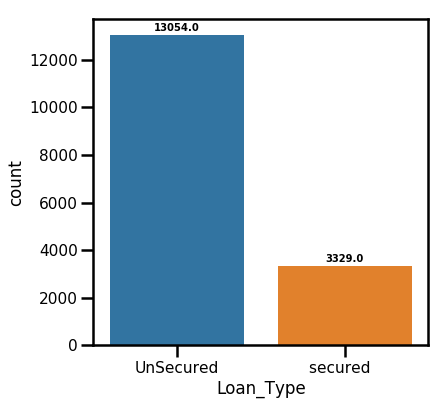

In [10]:
# unsecured and Secured Loan type
plt.figure(figsize=(6,6))
ax = sns.countplot(df['Loan_Type'])
showvalues(ax)

`Most of the loans are Unsecured which is ~ 4x of Secured loans.` 


Secured loans require that you offer up something you own of value as collateral in case you can't pay back your loan, whereas unsecured loans allow you borrow the money outright (after the lender considers your financials).

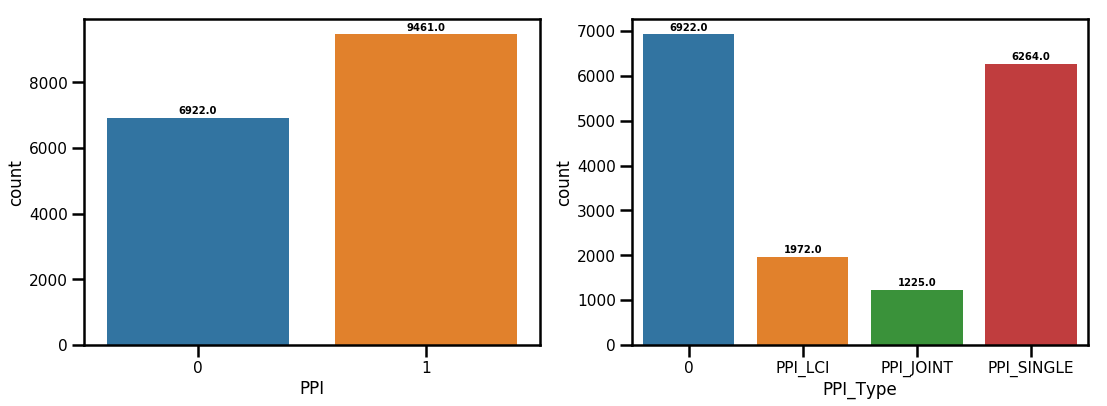

In [11]:
plt.figure(figsize=(18,6))
# plot for Customer who has PPI coverage or not 
plt.subplot(121)
ax = sns.countplot(df['PPI'])
showvalues(ax)
# plot for customers having different PPI coverages
plt.subplot(122)
ax = sns.countplot(df['PPI_Type'])
showvalues(ax)

`~ 7000 customers don't have any PPI coverages and majority of the PPI coverage users have PPI_SINGLE product `

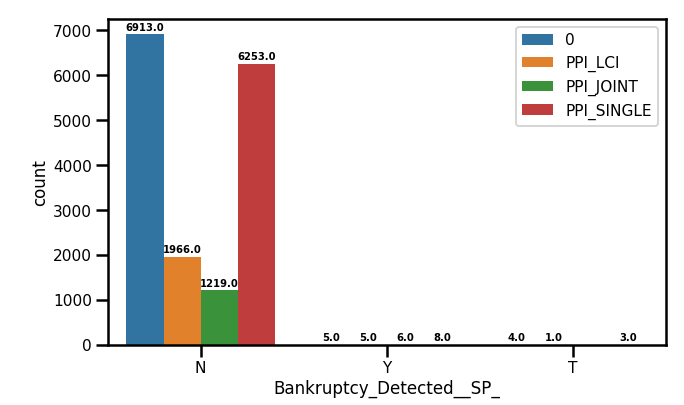

In [12]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x= 'Bankruptcy_Detected__SP_', data=df, hue='PPI_Type')
showvalues(ax)
ax.legend(loc='upper right')

` ~ 99% customer are not bankrupt or no bankruptcy detected. Customers who are bankrupt, giving them PPI coverages are not good for business or we can offer very high premium for these Customers`

### Bivariate Analysis

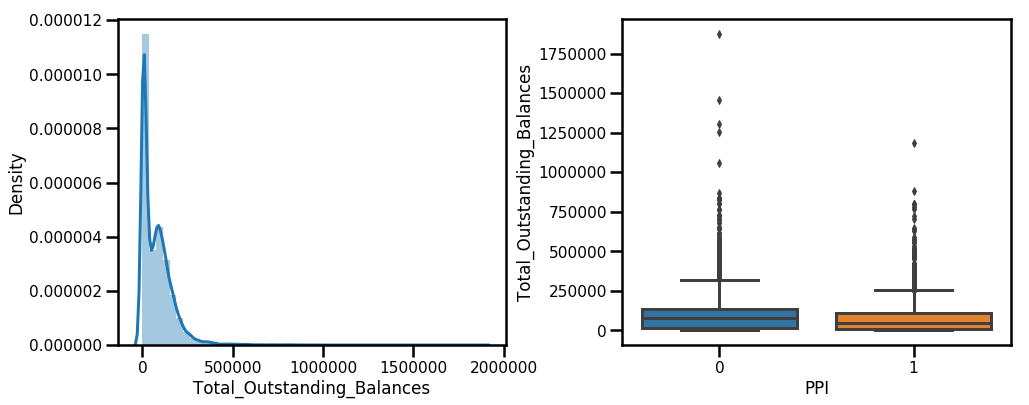

In [13]:
# Checking total outstanding balances 
plot_dist_box(df,'Total_Outstanding_Balances','PPI')

`Total outstanding balances has right skewed distribution as seen in distrbution plot and some customers have huge outstanding balance (ouliers) as we can see from box plot. `

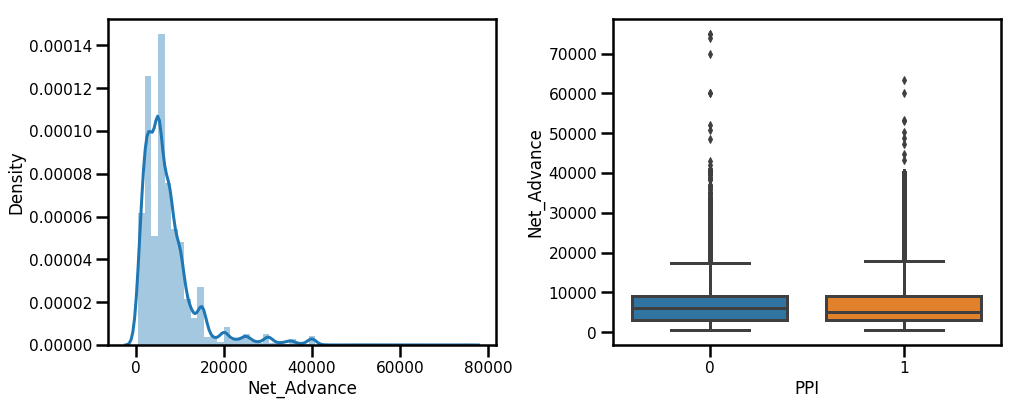

In [14]:
# Checking Net_Advance
plot_dist_box(df,'Net_Advance','PPI')

`Net Advance has right skewed distribution as seen in distrbution plot and some customers have huge Net_advance (ouliers) as we can see from box plot. Median for customers don't have PPI coverages are slightly larger than PPI customers.`

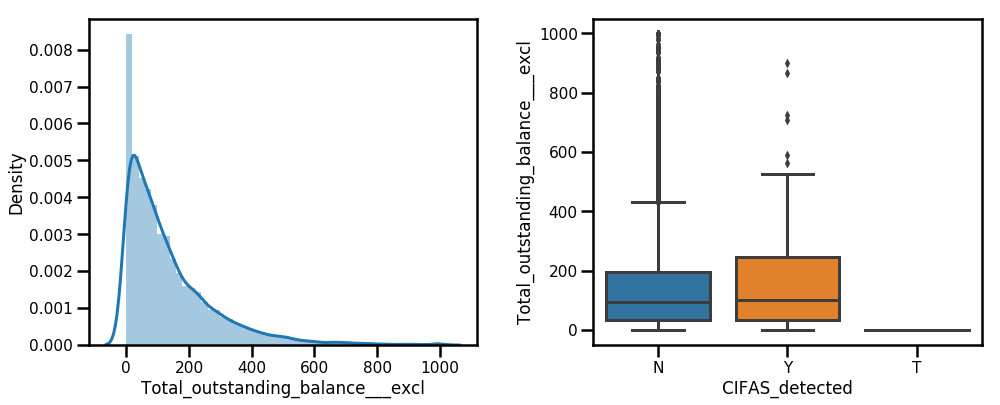

In [15]:
# Checking total outstanding balances 
plot_dist_box(df,'Total_outstanding_balance___excl','CIFAS_detected')

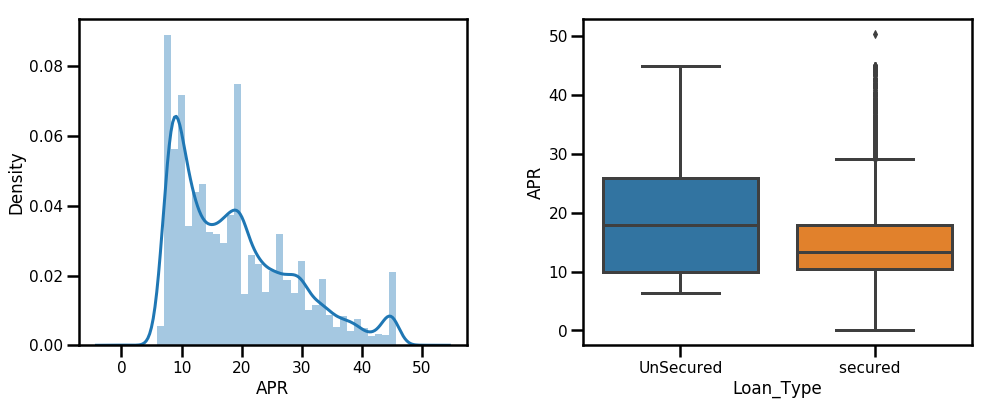

In [16]:
# Checking total outstanding balances 
plot_dist_box(df,'APR','Loan_Type')

`Annual Percentage Rate(APR) has right skewed distribution. APR for Unsecured loan is higher than secured customers as seen from the box plot and median for Unsecured and Secured loans. Secured loans has some customers (outliers) which have high APR compared to other secured customers`

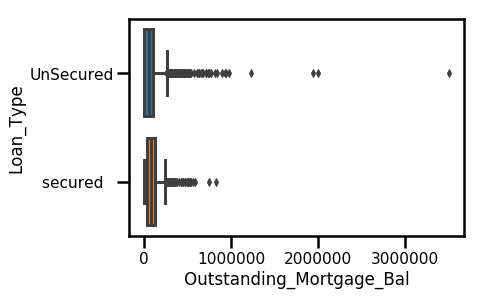

In [17]:
sns.boxplot(data=df,x= 'Outstanding_Mortgage_Bal',y= 'Loan_Type')

`Some customers for Secured and Unsecured loans have huge outstanding balances as seen from the above box plot`

In [18]:
# converting into categorical variables
df[['PPI','PPI_SINGLE','PPI_JOINT','PPI_LCI']] = df[['PPI','PPI_SINGLE','PPI_JOINT','PPI_LCI']].astype('object')

# categorical columns
df_cat = df.select_dtypes(exclude=['int64','float64'])

# Numerical Columns
df_num = df.select_dtypes(include=['int64','float64'])

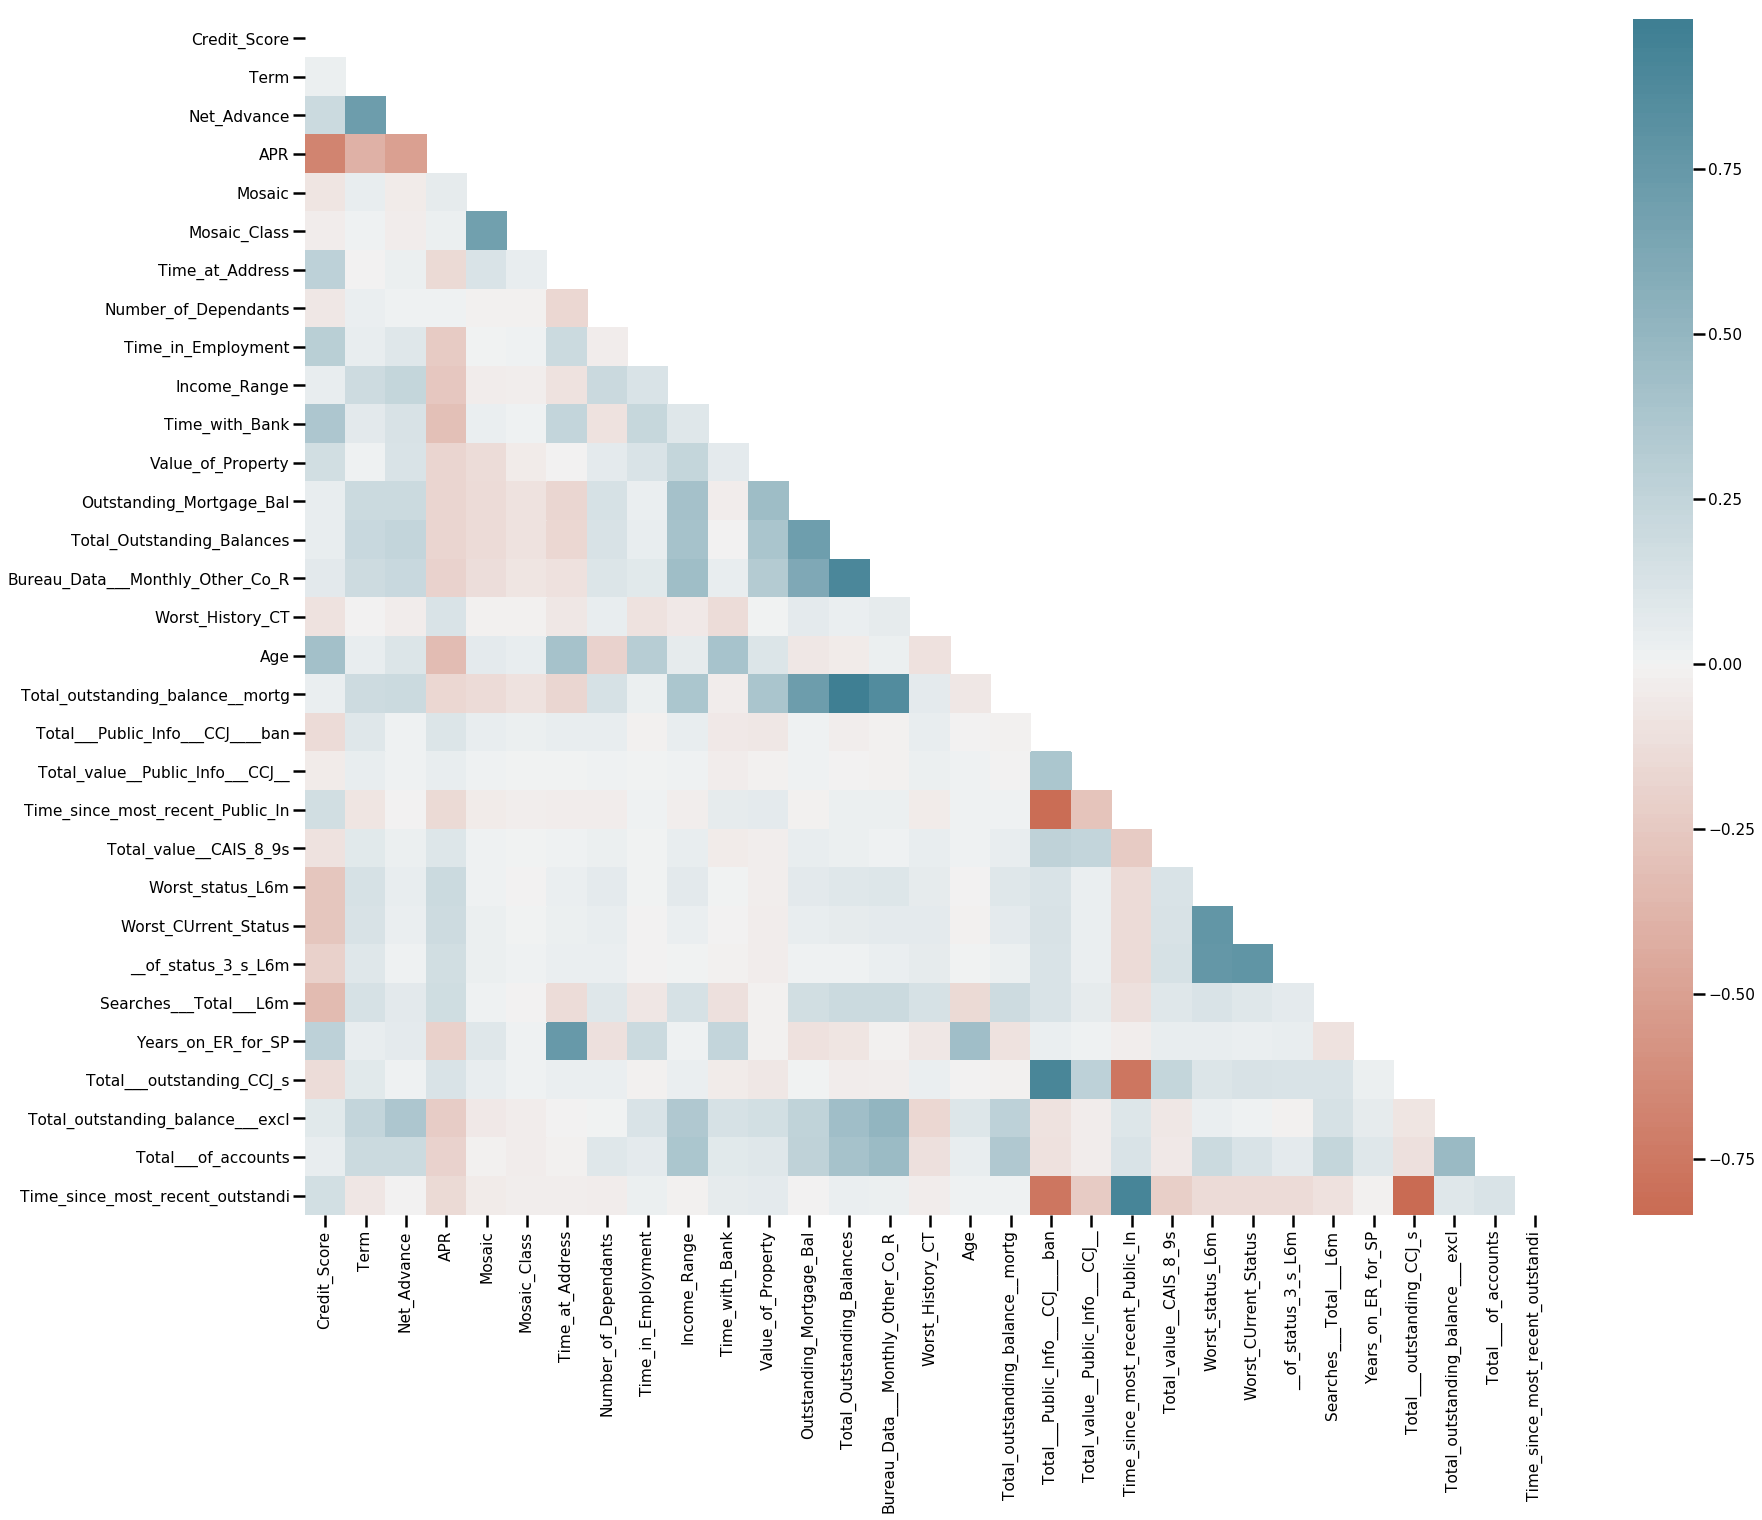

In [19]:
#Correlation between variables to check multicollinearity 
# Generate a mask for the upper triangle (taken from seaborn example gallery)
plt.subplots(figsize = (28,22))
mask = np.zeros_like(df_num.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Plotting heatmap
sns.heatmap(df_num.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=False, center = 0)


#### Highly correlated variables
- `Total_Outstanding_Balances` and `Total_outstanding_balance__mortg` are highly correlated, we can drop `Total_outstanding_balance__mortg`.
- `Time_since_most_recent_outstandi` and `Time_since_most_recent_Public_In` are are highly correlated, we can drop `Time_since_most_recent_Public_In`
- `Worst_CUrrent_Status` and `__of_status_3_s_L6m` are are highly correlated, we can drop `__of_status_3_s_L6m`
- `Worst_CUrrent_Status` and `Worst_status_L6m` are are highly correlated, we can drop `Worst_status_L6m`
- `Total_Outstanding_Balances` and `Bureau_Data___Monthly_Other_Co_R` are highly correlated, we can drop `Bureau_Data___Monthly_Other_Co_R`.
- `Term` and `Net_Advance` are highly correlated, we can drop `Net_Advance`.
- `Time_since_most_recent_outstandi` and `Total___Public_Info___CCJ____ban`, `Total___outstanding_CCJ_s` are are highly negatively correlated, we can drop `Total___Public_Info___CCJ____ban` and `Total___outstanding_CCJ_s`.


**We checked for corretion between two feature variables. It might happen that multiples columns are highly correlated with single column or multiple columns can predict difference fetaures. We can check VIF, p-values for taking care of those scenarios. Since we will do clustering later in this notebook, ignoring multicollinearity.**

In [20]:
# dropping highly correlated variables 
df.drop(['Total_outstanding_balance__mortg','Time_since_most_recent_Public_In','__of_status_3_s_L6m',
         'Worst_status_L6m','Bureau_Data___Monthly_Other_Co_R','Net_Advance','Total___Public_Info___CCJ____ban',
        'Total___outstanding_CCJ_s'],axis=1,inplace=True)

In [21]:
# dropping highly correlated variables from numerical columns dataframe
df_num.drop(['Total_outstanding_balance__mortg','Time_since_most_recent_Public_In','__of_status_3_s_L6m',
         'Worst_status_L6m','Bureau_Data___Monthly_Other_Co_R','Net_Advance','Total___Public_Info___CCJ____ban',
        'Total___outstanding_CCJ_s'],axis=1,inplace=True)

# Outlier Treatment

In [22]:
# Dropping/Removing outliers features having percentile less than 3% or more than 97%
Q1=df.Total_Outstanding_Balances.quantile(0.03)
Q3=df.Total_Outstanding_Balances.quantile(0.97)
IQR=Q3-Q1
df=df[(df.Total_Outstanding_Balances>=Q1-1.5*IQR)& (df.Total_Outstanding_Balances <= Q3 + 1.5*IQR)] 


Q1=df.Outstanding_Mortgage_Bal.quantile(0.03)
Q3=df.Outstanding_Mortgage_Bal.quantile(0.97)
IQR=Q3-Q1
df=df[(df.Outstanding_Mortgage_Bal>=Q1-1.5*IQR)& (df.Outstanding_Mortgage_Bal <= Q3 + 1.5*IQR)] 

In [23]:
PPI_Columns= ['PPI','PPI_SINGLE','PPI_JOINT','PPI_LCI','PPI_Type'] # list for storing multiple column names
df_org = df.copy()  # Copying dataframe for making inference later on test data with original values, not scaled or encoded.
df_org.drop(PPI_Columns,axis=1, inplace=True)

In [24]:
# Encoding Categorical Variables
df_cat = df_cat.drop(PPI_Columns,axis=1)  # dropping PPI_Columns not used for prediction 
le= LabelEncoder() # label encider object
df[df_cat.columns] = df[df_cat.columns].apply(le.fit_transform) # converting categorical columns into label
                                                               # encoded numerical features

In [25]:
# Normalising or Scaling Numerical values ( for faster optimisation, interpretation)
df[df_num.columns] = Normalizer().fit_transform(df[df_num.columns])  # Normalising numerical columns 

In [26]:
df_kproto_train= df[df['PPI']==1] # training datapoints for k prototype clustering Algorithm
df_kproto_train= df_kproto_train.drop(PPI_Columns,axis=1) # dropping target, unsupervised learning Algorithm

In [27]:
df_kproto_train[df_cat.columns]= df_kproto_train[df_cat.columns].apply(lambda x : x.astype('object'))
# k-means with some arbitrary k
kproto=KPrototypes(n_clusters=2,max_iter=100) # no of cluster = 2 
kproto.fit(df_kproto_train, categorical=[1,4,8,9,11,12,14,15,16,18,19,20,21,22,23,24,30,37,40])

KPrototypes(gamma=0.09951125357635927, n_clusters=2)

`I have divided data into 2 clusters. Reason: converting customers into two buckets/segments. One segment is customers not having huge outstanding balances, not bankrupted, etc (Good Cutomers), other bucket is for Bad customer for insurance company.`

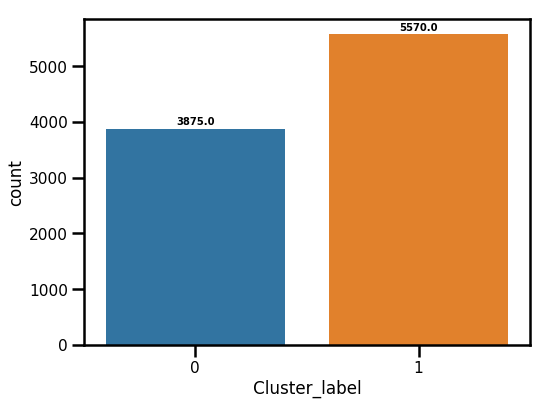

In [28]:
df_kproto_train['Cluster_label']=kproto.labels_
plt.figure(figsize=(8,6))
ax = sns.countplot(df_kproto_train['Cluster_label'])
showvalues(ax)

`Cluster label 1 have 5570 customers (Good customers) where Cluster label 0 have 3875 customers (Bad customers). We will apply these trained model on test data and will select customers belonging to Label 1 because those customer will be our potential customers for PPI coverage.`

In [29]:
print(kproto.labels_)
#vprint(kproto.cluster_centroids_)
print(len(kproto.labels_))

[0 0 1 ... 1 1 1]
9445


In [30]:
df_kproto_test= df[df['PPI']==0] # testing samples
df_kproto_test= df_kproto_test.drop(PPI_Columns,axis=1)  # dropping PPI_columns which is of no use
prediction = kproto.predict(df_kproto_test, categorical=[1,4,8,9,11,12,14,15,16,18,19,20,21,22,23,24,30,37,40])

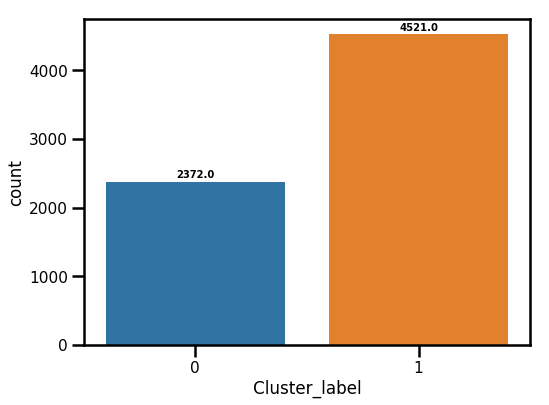

In [31]:
df_kproto_test['Cluster_label']=prediction
plt.figure(figsize=(8,6))
ax = sns.countplot(df_kproto_test['Cluster_label'])
showvalues(ax)

`Out of 6893 customers who don't have any PPI coverage product, we selected 4521 customers are potential customers for insurance company in terms of cross selling.`

**We will use these `4521` customers for predicting different `PPI coverages (PPI Single, PPI Joint, PPI LCI)` for these customers using Classification Model (RandomForestClassifier).**

In [32]:
# df_kproto_train.to_csv('df_kpro.csv')

# Data Modeling

### Modeling and Prediction with target labels ('PPI_SINGLE','PPI_JOINT','PPI_LCI') 

In [33]:
# dropping PPI coverages columns as we have new col PPI_Type which have all the information from all these columns
df = df.drop(['PPI','PPI_SINGLE','PPI_JOINT','PPI_LCI'],axis=1) 
# label encoding for output/target lables ('PPI_SINGLE':1,'PPI_JOINT':2,'PPI_LCI':3)
df['PPI_Type']= df['PPI_Type'].map({'PPI_SINGLE':1,'PPI_JOINT':2,'PPI_LCI':3,0:0})

In [34]:
test_sample_idx= list(df_kproto_test[df_kproto_test['Cluster_label']==1].index) # data points for test data
train_sample_idx = list(df_kproto_train.index) # samples for train data

In [35]:
X = (df.loc[train_sample_idx]).drop('PPI_Type',axis=1) # dropping target columns for training features
y = (df.loc[train_sample_idx])['PPI_Type'] # target variable

In [36]:
# train test split (90-10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)
print(X_train.shape)
print(X_val.shape)

(8500, 42)
(945, 42)


In [37]:
# cross validation and hyperparamter tuning
kfold=KFold(n_splits=5,random_state=42,shuffle=True)
params = {
    'min_samples_leaf': [2,5],
    'n_estimators': [200]
}
grid_rfc= GridSearchCV(RandomForestClassifier(class_weight='balanced'),param_grid=params,scoring='accuracy',return_train_score=True)
grid_rfc.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'min_samples_leaf': [2, 5], 'n_estimators': [200]},
             return_train_score=True, scoring='accuracy')

In [38]:
print(grid_rfc.best_params_) # best paramters
print(grid_rfc.best_score_) # cv score best estimator score

{'min_samples_leaf': 2, 'n_estimators': 200}
0.681764705882353


In [39]:
grid_rfc= grid_rfc.best_estimator_ # best random foresr model/estimator

In [40]:
val_accuracy = grid_rfc.score(X_val,y_val)
val_accuracy

0.692063492063492

`Acheived accuracy of ~ 70% which can be improved using feature engineering, more tuning and appying boosting algos. I have implemented simpler model which is working fine for iur dataset.` 

## Model Prediction 

In [41]:
X_test = (df.loc[test_sample_idx]).drop('PPI_Type',axis=1)
test_prediction= grid_rfc.predict(X_test)
test_prediction

array([1, 1, 1, ..., 1, 1, 1])

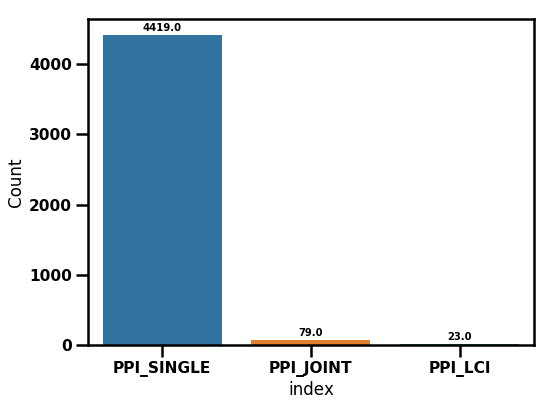

In [86]:
plot_df = pd.DataFrame(pd.Series(test_prediction).value_counts(),columns=['Count'])
plot_df['index']= ['PPI_SINGLE','PPI_JOINT','PPI_LCI']
plot_df.set_index('index',inplace=True)
plt.figure(figsize=(8,6))
ax = sns.barplot(x=plot_df.index,y=plot_df.Count)
showvalues(ax)

**Out of 4521 customers , we suggest `PPI_SINGLE to 4419 customers, PPI_JOINT to 79 and PPI_LIC to 23 customers`.**

#### Feature Imprtance

In [88]:
# Check the feature importance score for each feature
feat_imp_df = pd.DataFrame({'Feature':X_train.columns, 'Score':grid_rfc.feature_importances_})
feat_imp_df = feat_imp_df.sort_values('Score', ascending=False,ignore_index=True) # Order features by score
feat_imp_df.head(10)

,Feature,Score
0,Income_Range,0.06
1,Age,0.05
2,Value_of_Property,0.05
3,Time_in_Employment,0.05
4,Time_with_Bank,0.04
5,Total_outstanding_balance___excl,0.04
6,APR,0.04
7,Time_at_Address,0.04
8,Total_Outstanding_Balances,0.04
9,Employment_Status,0.04


`Income_Range explained the highest variance (6%) for prediction of PPI coverages for cutomers. Age, Value of Property, Time in employement are explaining each 5% variance.` 

**These Top 10 features are most imortance feature predictors for suggesting different PPI Coverages.**

In [45]:
col = list(feat_imp_df['Feature'][:10])
feat_imp= list(feat_imp_df['Score'][:10])

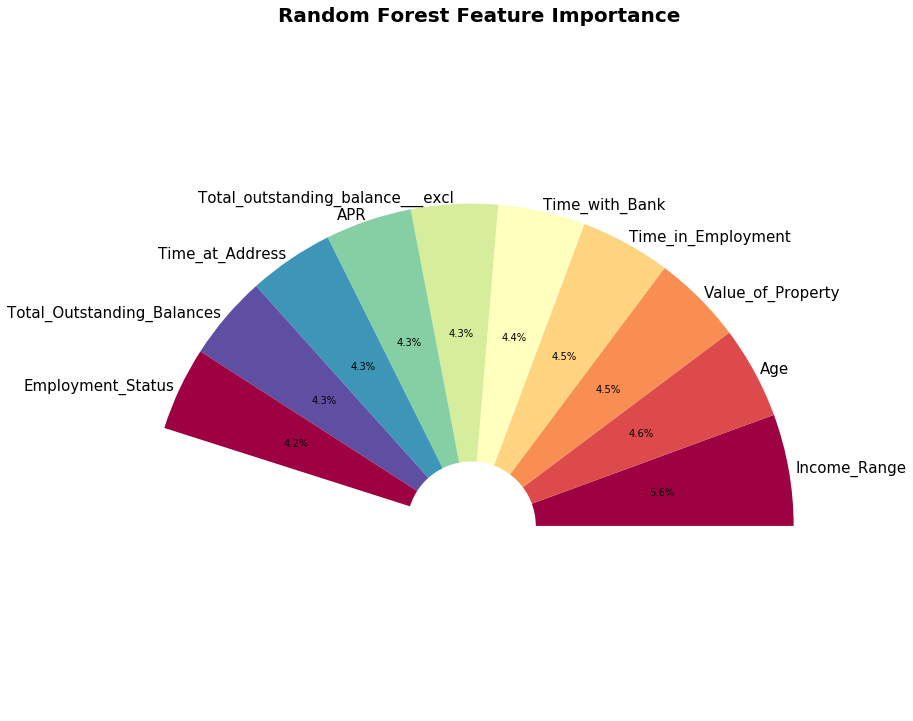

In [46]:
# feature importance Pie Chart for Random Forest 
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 9)]
plt.figure(figsize=(10,10))
wedges, labels, autopct = plt.pie(feat_imp, labeldistance=1.02,labels=col,autopct='%1.1f%%', shadow=False, colors=colors)
for lab in labels:
    lab.set_fontsize(15)
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'bold'
centre_circle = plt.Circle((0,0),0.2,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')  
plt.tight_layout()
plt.title('Random Forest Feature Importance',fontweight='bold',size=20)
plt.show()

In [61]:
df_org_test= df_org.loc[test_sample_idx]  # Original Data Frame, not having normalised or encoded labels
df_org_test['PPI_Type']= test_prediction
df_org_test['PPI_Type'] = df_org_test['PPI_Type'].map({1:'PPI_SINGLE',2:'PPI_JOINT',3:'PPI_LCI'})
df_org_test.head(2)

,Credit_Score,Final_Grade,Term,APR,Loan_Type,Mosaic,Mosaic_Class,Time_at_Address,Residential_Status,Telephone_Indicator,...,Total_value__CAIS_8_9s,Worst_CUrrent_Status,Searches___Total___L6m,Years_on_ER_for_SP,Bankruptcy_Detected__SP_,Total_outstanding_balance___excl,Total___of_accounts,CIFAS_detected,Time_since_most_recent_outstandi,PPI_Type
0,918,A,36,14.40,UnSecured,46,8,132,H,Y,...,0,0,9,10,N,18,6,N,16,1
7,961,X,60,11.90,secured,43,7,163,H,N,...,175,0,6,8,N,113,8,N,7,1


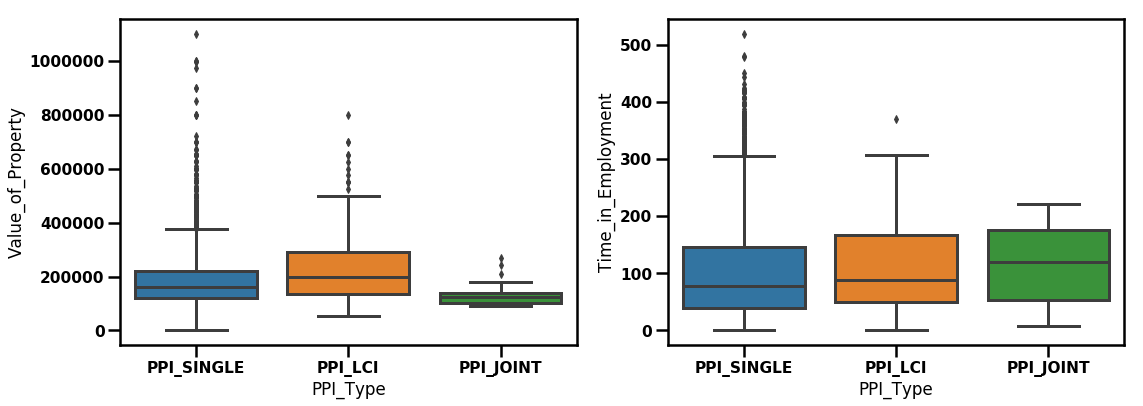

In [90]:
plt.figure(figsize=(18,6))
# plot for Customer who has PPI coverage or not 
plt.subplot(121)
sns.boxplot(data= df_org_test,y= 'Value_of_Property',x= 'PPI_Type')
# plot for customers having different PPI coverages
plt.subplot(122)
sns.boxplot(data= df_org_test,y= 'Time_in_Employment',x= 'PPI_Type')
plt.show()

`PPI_LCI product customers are having high value of property compared to Joint and Single. Median for PPI_LCI is significantly above than Single and Joint. PPI_Joint product cutomers are having low value of property among all.`

`Time in Employemetn for PPI_Joint products customers has significantly high value compared to LCI and Single. PPI_Single have some customer which have large  Time in Employement`

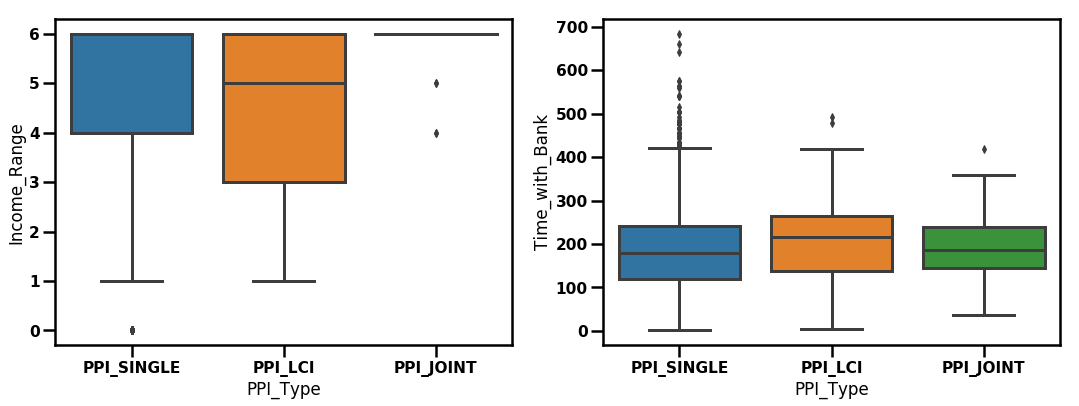

In [91]:
plt.figure(figsize=(18,6))
# plot for Customer who has PPI coverage or not 
plt.subplot(121)
sns.boxplot(data= df_org_test,y= 'Income_Range',x= 'PPI_Type')
# plot for customers having different PPI coverages
plt.subplot(122)
sns.boxplot(data= df_org_test,y= 'Time_with_Bank',x= 'PPI_Type')
plt.show()

`Except 2 customers all PPI_Joint suggested customers have Income Range = 6. PPI_Single Customers have also median and max of Income range = 6 which implies most of the customers suggested PPI_Single coverage have Income range of 6.`

`Time with bank for PPI_LCI product is higher than Single and Joint Customers`

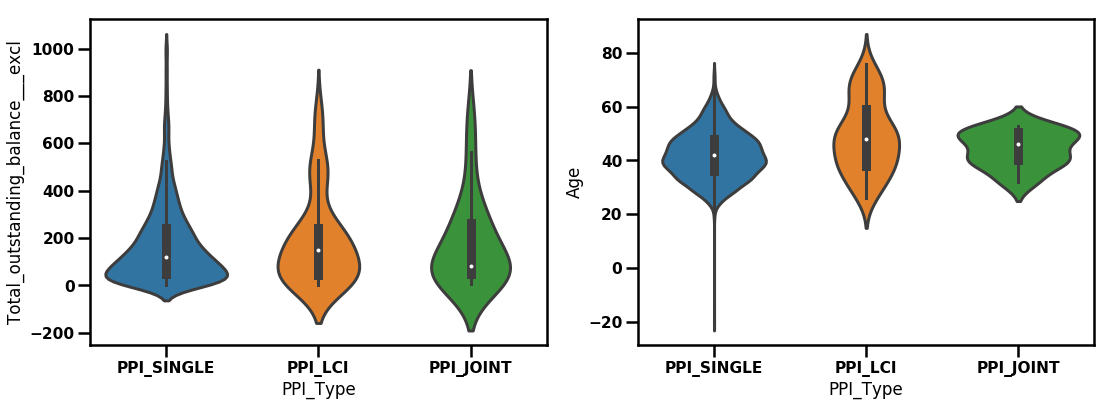

In [92]:
plt.figure(figsize=(18,6))
# plot for Customer who has PPI coverage or not 
plt.subplot(121)
sns.violinplot(data= df_org_test,y= 'Total_outstanding_balance___excl',x= 'PPI_Type')
# plot for customers having different PPI coverages
plt.subplot(122)
sns.violinplot(data= df_org_test,y= 'Age',x= 'PPI_Type')
plt.show()

`PPI_Joint customers have less Total Outstanding balance compared to Single and LCI, whereas LCI has more customers having high Total Outstanding balance`

`PPI_JOINT, PPI_LCI, PPI_SINGLE doesn't have significant difference in terms of AGE`

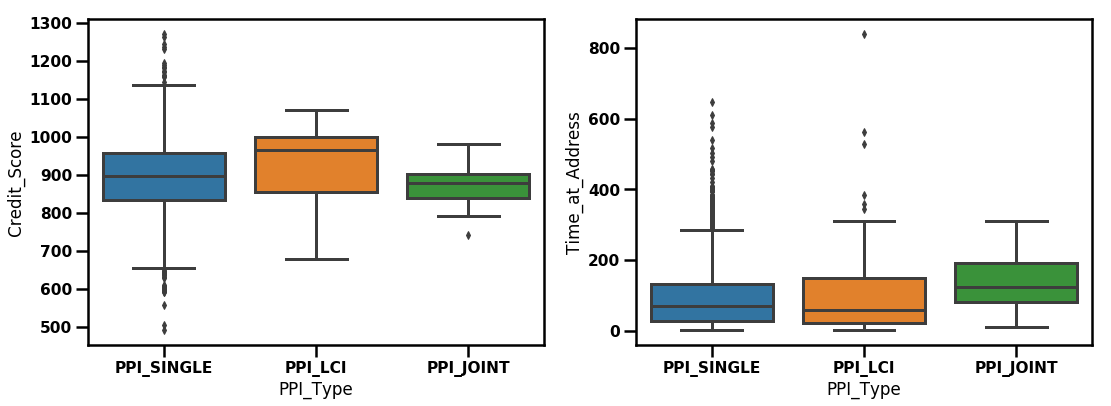

In [93]:
plt.figure(figsize=(18,6))
# plot for Customer who has PPI coverage or not 
plt.subplot(121)
sns.boxplot(data= df_org_test,y= 'Credit_Score',x= 'PPI_Type')
# plot for customers having different PPI coverages
plt.subplot(122)
sns.boxplot(data= df_org_test,y= 'Time_at_Address',x= 'PPI_Type')
plt.show()

`PPI_LCI have large no customers having High credit Score compared to Joint and Single PPI Coverage customers.`

`Time at given Address for PPI Joint customers are larger than Single and LCI.`

<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:tomato' role="tab" aria-controls="home"><center>Thank You 🙂</center></h2>
